In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import json

def parquet_dir_to_df(dirpath):
    df = pd.DataFrame()
    for filename in sorted(os.listdir(dirpath)):
        if filename.endswith('.parquet') or filename.endswith('.parquet.gzip'):
            filepath = os.path.join(dirpath, filename)
            df = df.append(pd.read_parquet(filepath))
    return df

# 1. Pre-process docker stats

In [3]:
docker_stats_json_path = 'docker_stats.json'
container_rename_dict = {'/social-network-backend': 'backend', '/social-network-postgres': 'db-master'}


In [4]:
docker_stats_list = json.load(open(docker_stats_json_path, 'r'))
docker_stats_df = pd.DataFrame(docker_stats_list)

docker_stats_df = docker_stats_df[docker_stats_df['name'].isin(container_rename_dict)]
docker_stats_df['name'] = docker_stats_df['name'].map(container_rename_dict)

docker_stats_df['Timestamp'] = (pd.to_datetime(docker_stats_df['read']) - pd.Timestamp("1970-01-01", tz='utc')) // pd.Timedelta('1s')

docker_stats_df['cpu'] = docker_stats_df['cpu_stats'].apply(lambda x: x['cpu_usage']['total_usage'])

docker_stats_df['ram'] = docker_stats_df['memory_stats'].apply(lambda x: x['usage'])

docker_stats_df['net_rx_bytes'] = docker_stats_df['networks'].apply(lambda x: x['eth0']['rx_bytes'])
docker_stats_df['net_tx_bytes'] = docker_stats_df['networks'].apply(lambda x: x['eth0']['tx_bytes'])

docker_stats_df['disk_read'] = docker_stats_df['blkio_stats'].apply(lambda x: [y['value'] for y in x['io_service_bytes_recursive'] if y['op'] == 'read'][0])
docker_stats_df['disk_write'] = docker_stats_df['blkio_stats'].apply(lambda x: [y['value'] for y in x['io_service_bytes_recursive'] if y['op'] == 'write'][0])


drop_cols = ['read', 'preread', 'num_procs', 'storage_stats', 'pids_stats', 'precpu_stats', 'id', 'blkio_stats', 'cpu_stats', 'memory_stats', 'networks']
docker_stats_df.drop(columns=drop_cols, inplace=True)

In [5]:
docker_stats_df

,name,Timestamp,cpu,ram,net_rx_bytes,net_tx_bytes,disk_read,disk_write
0,backend,1688813051,482901199000,120459264,304764744,239306628,41947136,0
4,db-master,1688813058,38671171000,750620672,46039291,280149512,590016512,5230592
5,backend,1688813060,485956518000,120434688,304764744,239306628,41947136,0
9,db-master,1688813068,38708476000,750616576,46053151,280221201,590016512,5271552
10,backend,1688813070,489473255000,120438784,304764744,239306628,41947136,0
...,...,...,...,...,...,...,...,...
414,db-master,1688813874,85024771000,753156096,104749820,628884019,590016512,8941568
415,backend,1688813876,894236143000,137113600,691059147,542920600,41947136,0
419,db-master,1688813884,85057731000,753156096,104764340,628955788,590016512,9011200
420,backend,1688813886,897597220000,137109504,691059147,542920600,41947136,0


# 2. Pre-process locust stats

In [6]:
locust_stats_parquet_dir = 'loadtest_stats_history'

In [7]:
load_test_stats_df = parquet_dir_to_df(locust_stats_parquet_dir)

load_test_stats_df = load_test_stats_df[load_test_stats_df['User Count'] != 0]
load_test_stats_df = load_test_stats_df[load_test_stats_df['op_type'] == 'agg']

/var/folders/cv/_5p_r3x521s1plhh5ghyn8340000gn/T/ipykernel_70776/155342514.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_parquet(filepath))
/var/folders/cv/_5p_r3x521s1plhh5ghyn8340000gn/T/ipykernel_70776/155342514.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_parquet(filepath))
/var/folders/cv/_5p_r3x521s1plhh5ghyn8340000gn/T/ipykernel_70776/155342514.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_parquet(filepath))
/var/folders/cv/_5p_r3x521s1plhh5ghyn8340000gn/T/ipykernel_70776/155342514.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = d

In [8]:
phase_starts = load_test_stats_df.groupby('User Count')['Timestamp'].min().reset_index()
phase_starts_dict = dict(zip(phase_starts['User Count'], phase_starts['Timestamp']))
phase_starts_dict

{1: 1688813126, 10: 1688813307, 100: 1688813487, 1000: 1688813669}

In [9]:
phase_starts_plus_60_dict = {k: v + 60 for k, v in phase_starts_dict.items()}
phase_starts_plus_60_dict

{1: 1688813186, 10: 1688813367, 100: 1688813547, 1000: 1688813729}

In [10]:
phases = sorted(phase_starts_dict.keys())
starts = [phase_starts_dict[k] for k in phases]
true_starts = [phase_starts_plus_60_dict[k] for k in phases]
ends = [phase_starts_dict[k] for k in phases[1:]] + [load_test_stats_df['Timestamp'].max()]
phase_interval_dict = dict(zip(phases, list(zip(true_starts, ends))))
phase_interval_dict

{1: (1688813186, 1688813307),
 10: (1688813367, 1688813487),
 100: (1688813547, 1688813669),
 1000: (1688813729, 1688813845)}

In [11]:
drop_cols = ['Type', '66%', '75%', '80%', '90%', '98%', '99%', '99.9%', '99.99%', '100%',
             'Total Failure Count', 'Total Median Response Time', 'Total Average Response Time',
             'Total Min Response Time', 'Total Max Response Time', 'Total Average Content Size',
             'is_agg', 'is_user_get', 'is_user_search', 'get_id', 'search_fname', 'search_lname',
             'op_type', 'Failures/s']

load_test_stats_df.drop(columns=drop_cols, inplace=True)

In [12]:
load_test_stats_df['User Count'].value_counts(dropna=False)

1       153
10       91
100      60
1000     45
Name: User Count, dtype: int64

In [13]:
load_test_stats_df['cutoff_time'] = load_test_stats_df['User Count'].map(phase_starts_plus_60_dict)
load_test_stats_df = load_test_stats_df[load_test_stats_df['Timestamp'] >= load_test_stats_df['cutoff_time']]
load_test_stats_df.drop(columns=['cutoff_time'], inplace=True)

In [14]:
load_test_stats_df

,Timestamp,User Count,Requests/s,50%,95%,Total Request Count
86896,1688813186,1,49.9,5.0,47.0,3111
90030,1688813187,1,50.1,5.0,47.0,3159
93220,1688813188,1,49.6,5.0,47.0,3216
96467,1688813189,1,49.1,5.0,47.0,3273
99766,1688813190,1,48.8,5.0,47.0,3327
...,...,...,...,...,...,...
8398728,1688813827,1000,127.7,9300.0,12000.0,90045
8466978,1688813832,1000,127.7,12000.0,12000.0,90045
8535353,1688813836,1000,102.5,9000.0,12000.0,90257
8604271,1688813840,1000,21.2,9400.0,12000.0,91250


# 3. Process docker stats

In [15]:
def get_phase(timestamp, phase_interval_dict):
    for phase, interval in phase_interval_dict.items():
        if interval[0] <= timestamp <= interval[1]:
            return phase
    return None

In [16]:
docker_stats_df['User Count'] = docker_stats_df['Timestamp'].apply(lambda x: get_phase(x, phase_interval_dict))
docker_stats_df.dropna(inplace=True, subset=['User Count'])
docker_stats_df['User Count'] = docker_stats_df['User Count'].astype(int)

In [17]:
docker_stats_df

,name,Timestamp,cpu,ram,net_rx_bytes,net_tx_bytes,disk_read,disk_write,User Count
69,db-master,1688813188,41618165000,752668672,48418505,298110555,590016512,5820416,1
70,backend,1688813190,536699157000,130052096,323673419,254360898,41947136,0,1
74,db-master,1688813199,41934669000,752672768,48767145,300135455,590016512,5861376,1
75,backend,1688813201,540888690000,130064384,325685310,255950244,41947136,0,1
79,db-master,1688813209,42234457000,752672768,49094368,301702278,590016512,5902336,1
...,...,...,...,...,...,...,...,...,...
390,backend,1688813826,874285921000,138723328,685488919,538514947,41947136,0,1000
394,db-master,1688813833,84281973000,753156096,103923115,623963051,590016512,8777728,1000
395,backend,1688813835,877752242000,137826304,685832288,538723763,41947136,0,1000
399,db-master,1688813843,84958855000,753156096,104706374,628659480,590016512,8818688,1000


In [18]:
load_test_stats_df

,Timestamp,User Count,Requests/s,50%,95%,Total Request Count
86896,1688813186,1,49.9,5.0,47.0,3111
90030,1688813187,1,50.1,5.0,47.0,3159
93220,1688813188,1,49.6,5.0,47.0,3216
96467,1688813189,1,49.1,5.0,47.0,3273
99766,1688813190,1,48.8,5.0,47.0,3327
...,...,...,...,...,...,...
8398728,1688813827,1000,127.7,9300.0,12000.0,90045
8466978,1688813832,1000,127.7,12000.0,12000.0,90045
8535353,1688813836,1000,102.5,9000.0,12000.0,90257
8604271,1688813840,1000,21.2,9400.0,12000.0,91250


# 4. Save processed datasets

In [19]:
load_test_stats_df.to_csv('processed_data/load_test_stats.csv', index=False)
docker_stats_df.to_csv('processed_data/docker_stats.csv', index=False)

# 5. Plotting

In [20]:
def plot2(df, column, title, category_col, sharey=True, logy=False):
    df = df.rename(columns={column: title})

    plot = sns.catplot(
        data=df, kind="box",
        x=category_col, y=title, hue=category_col, col="User Count",
        sharey=sharey
    )

    [ax.grid(axis='y') for ax in plot.axes.flatten()]
    if logy:
        [ax.set_yscale('log') for ax in plot.axes.flatten()]

    return plot

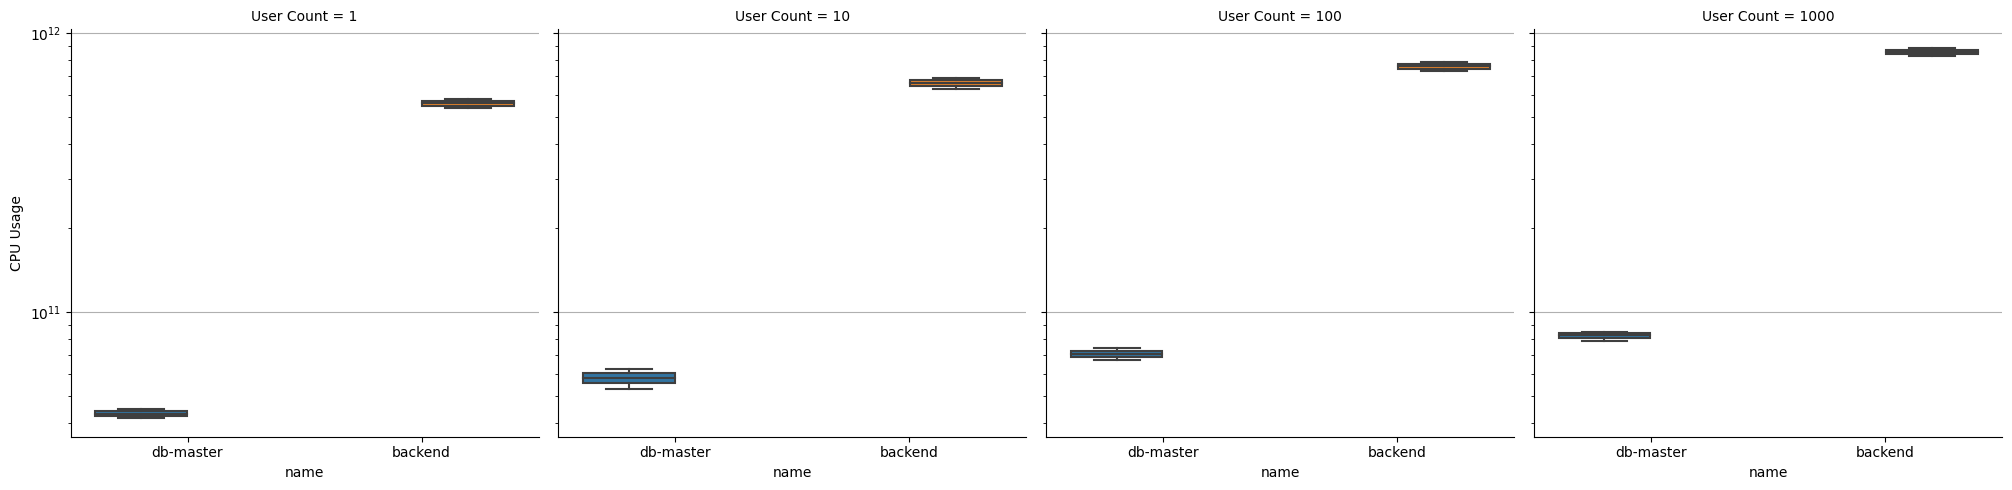

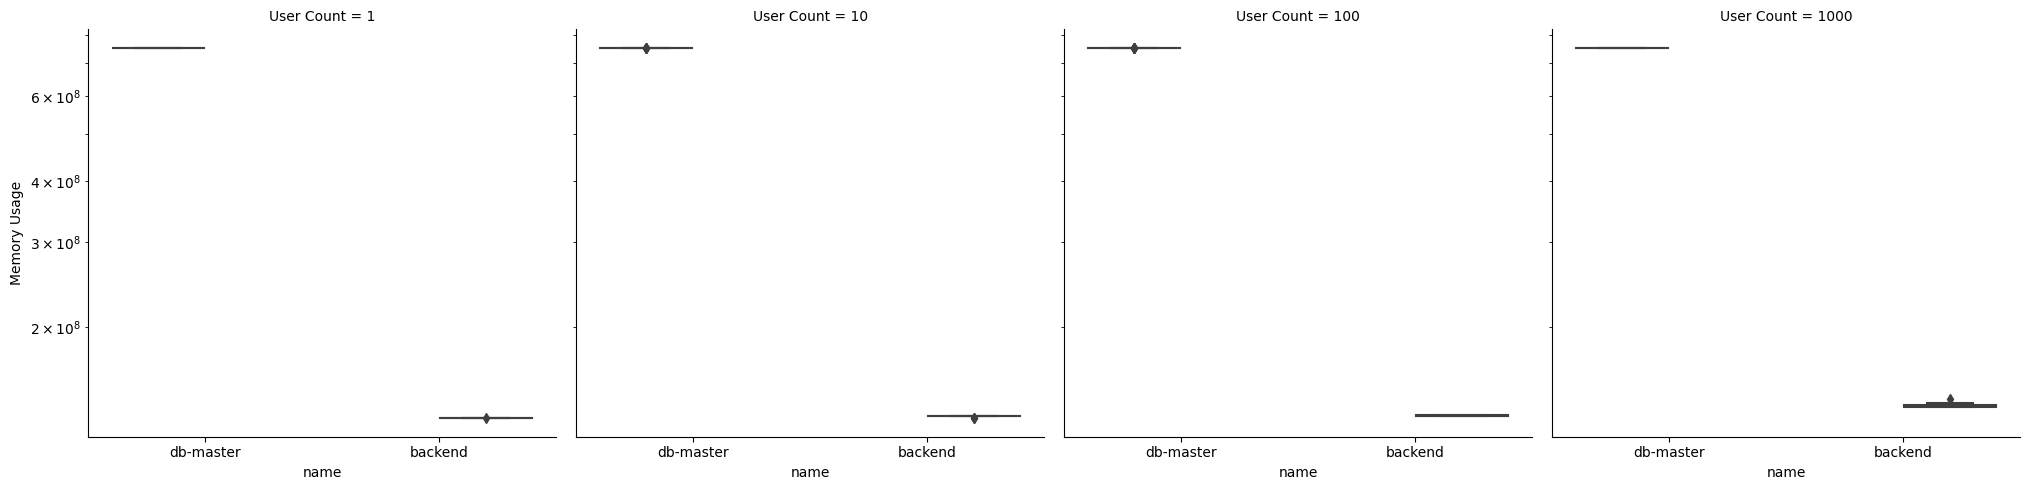

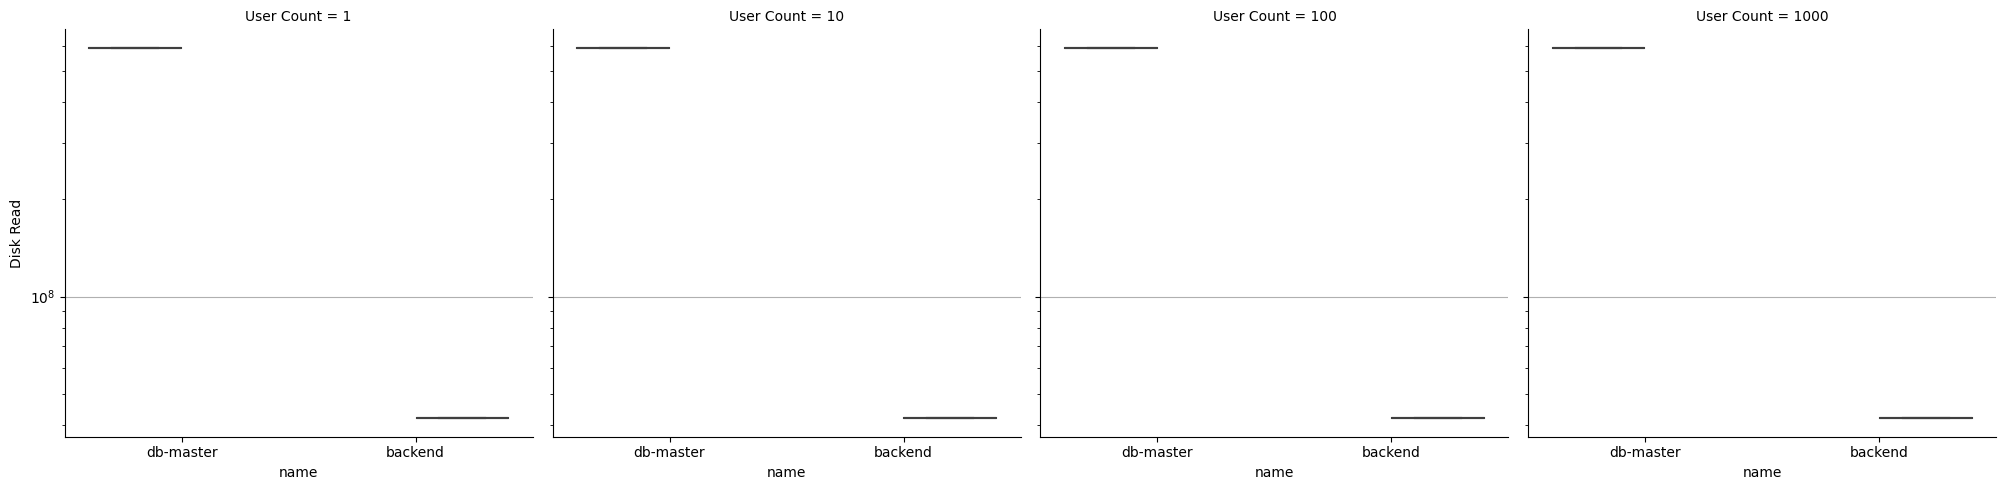

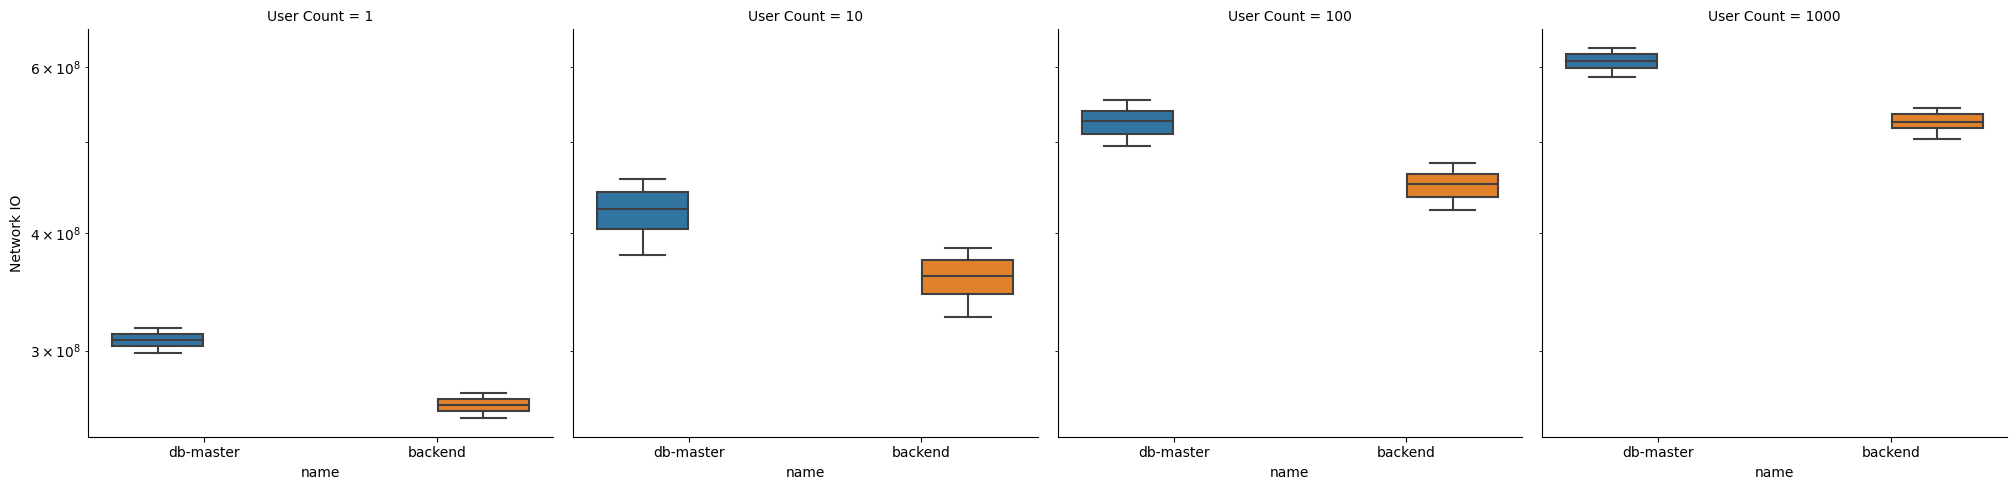

In [21]:
plot2(docker_stats_df, 'cpu', 'CPU Usage', 'name', sharey=True, logy=True)
plot2(docker_stats_df, 'ram', 'Memory Usage', 'name', sharey=True, logy=True)
plot2(docker_stats_df, 'disk_read', 'Disk Read', 'name', sharey=True, logy=True)
plot2(docker_stats_df, 'net_tx_bytes', 'Network IO', 'name', sharey=True, logy=True)

In [22]:
load_test_stats_df['name'] = 'master only'

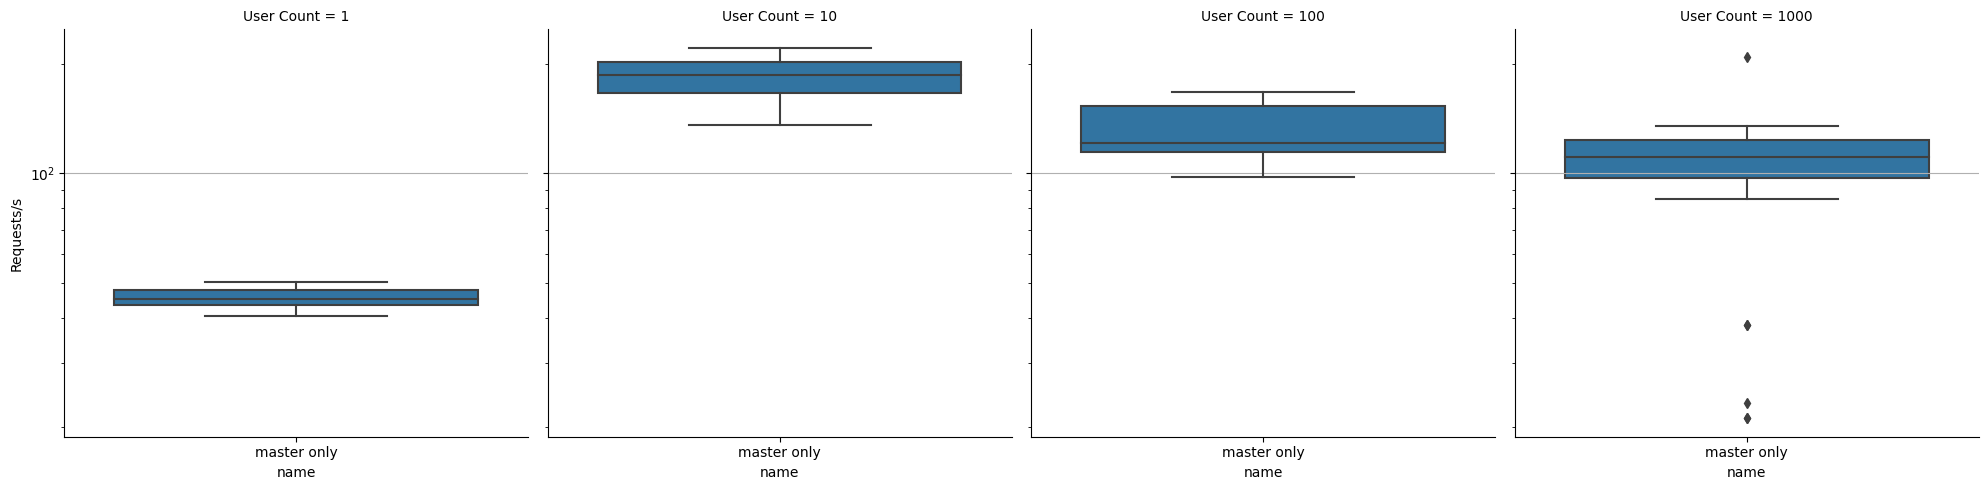

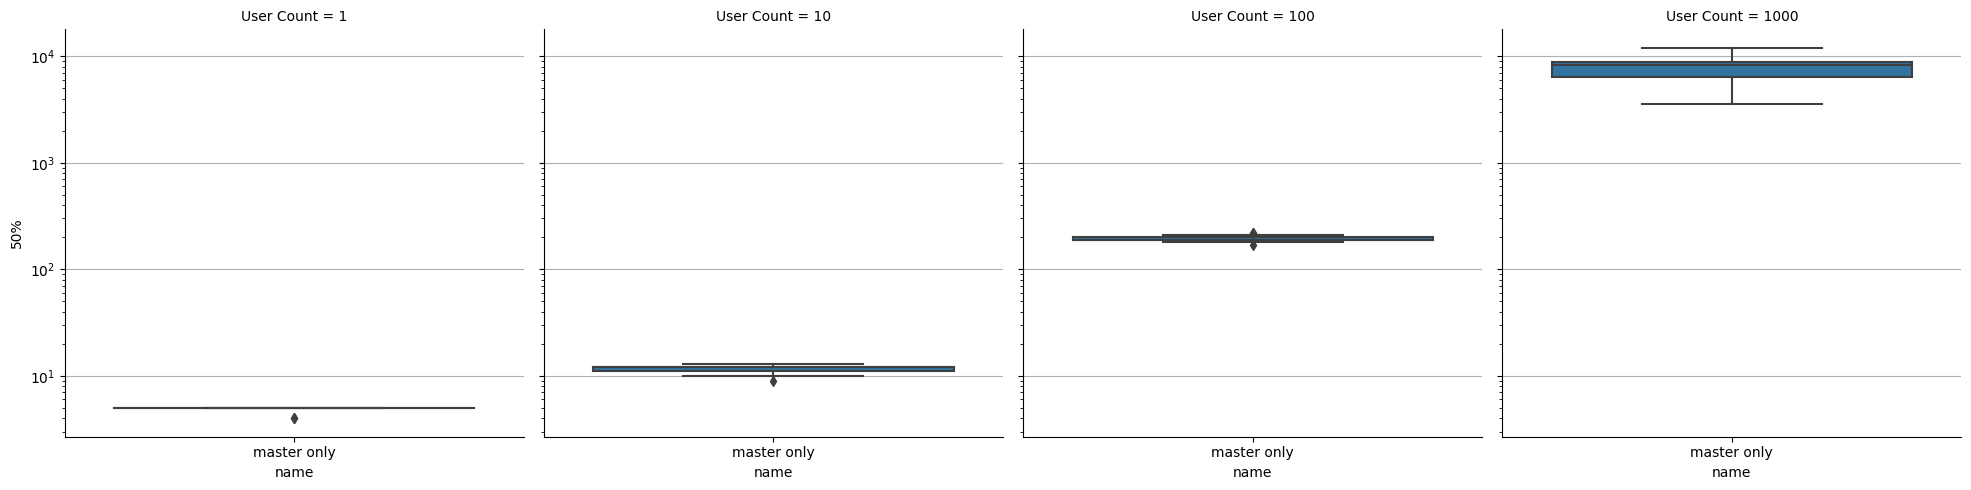

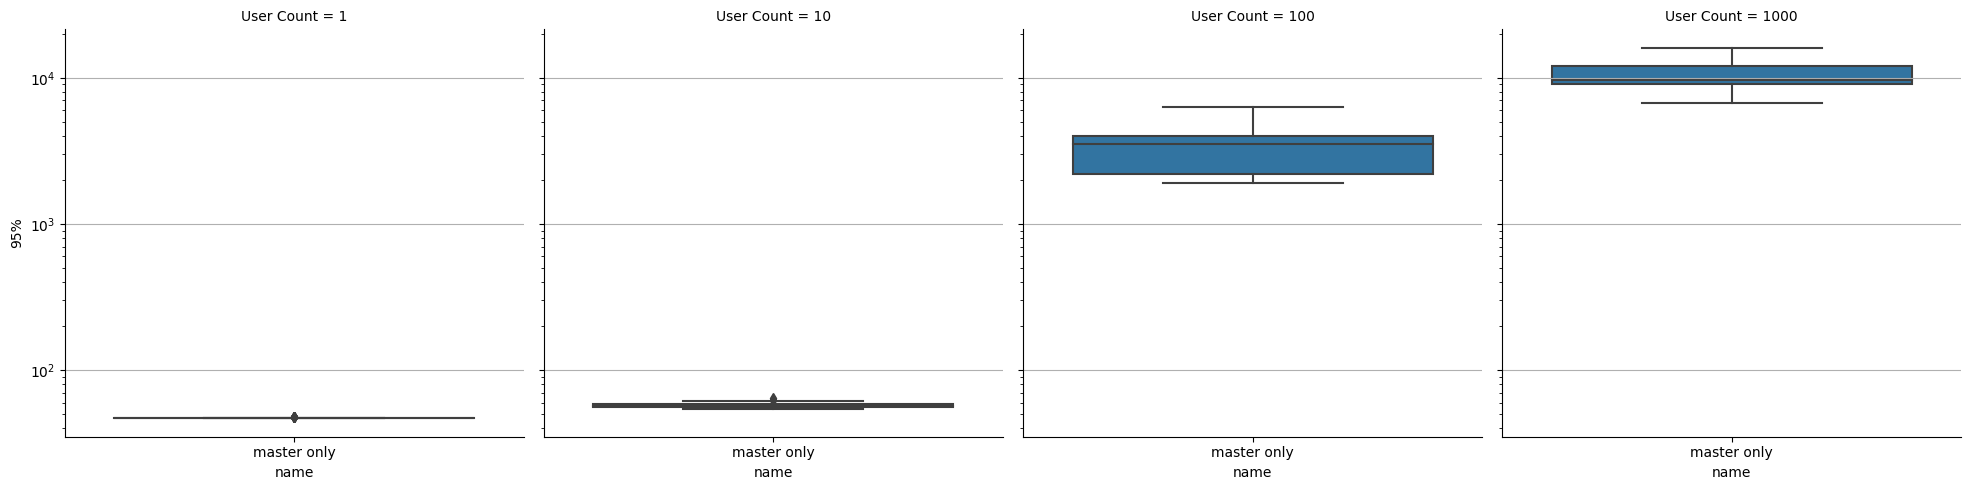

In [25]:
plot2(load_test_stats_df, 'Requests/s', 'Requests/s', 'name', sharey=True, logy=True)
plot2(load_test_stats_df, '50%', '50%', 'name', sharey=True, logy=True)
plot2(load_test_stats_df, '95%', '95%', 'name', sharey=True, logy=True)